In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pylab import *

In [4]:
data = pd.read_csv('dataset.csv')

In [5]:
data.head()

,Unnamed: 0,shopping_center_id,device_local_date,device_hash_id,day,hour
0,0,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-14 10:00:25,6fdffac307,6,10
1,1,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-14 17:13:15,386141ebd8,6,17
2,2,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-14 09:07:06,b06242b848,6,9
3,3,b43e9e4f-acd1-4941-874d-e0c5650ab91e,2019-09-14 17:14:49,c13cc52e82,6,17
4,4,599cb959-11ef-49aa-9eb3-e6c17b4ea6ba,2019-09-14 10:17:35,f339ddf999,6,10


In [6]:
data.shape

(81838, 6)

# Checklist

## Hypothèse

- les horaires ne changent pas entre les semaines. 

## Analyse de la forme
- training set m=81838
- nombre de features n=6
- analyse des valeurs manquantes: aucune NaN. Il ne sera pas nécessaire d'extrapoler les valeurs.

## Analyse du fond
- A priori, pour une première étude, les variables suivantes ne présentent pas d'intérêt pour la résolution:
    * 'Unnamed: 0': index aléatoire
    * 'device_local_date': redondant avec les informations 'day', 'hour' et plus difficilement exploitable
    * 'device_hash_id': on calculera la fréquentation non pas à partir des hash_id mais du comptage des heures par jour, par magasin. En examinant de plus près les device_hash_id, on pourrait définir les hash qui se répètent tous les jours. Employés de la sécurité, de l'entretien? En tous cas ce ne sont pas des clients. Il faudrait supprimer ces hash qui parasitent le dataset dans le cas de cette étude.  	


In [7]:
#data.describe()

In [8]:
df = data.copy()

In [9]:
df.dtypes.value_counts()

object    3
int64     3
dtype: int64

## Recherche des valeurs manquantes (NaN)

In [10]:
#plt.figure(figsize = (20,10))
#sns.heatmap(df.isna(),cbar=False) --> pas de NaN visibles
print("Nombre de Nan =", df.isna().sum())

Nombre de Nan = Unnamed: 0            0
shopping_center_id    0
device_local_date     0
device_hash_id        0
day                   0
hour                  0
dtype: int64


La **colonne 'Unnamed: 0'** n'apporte aucune information utile. On la supprime.
De même, dans notre première approche on se limitera à la colonne day et hour du dataset, données retravaillées plus exploitables que 'device_local_date' **on supprime donc 'device_local_date'**. 
Pour l'instant on n'étudie pas la récurrence des device_bash_id, la fréquentation se calcule à partir du nombre d'occurence de "hour" par "day". **On peut supprimer "device_hash_id"**.

## Création du dataframe - suppression des colonnes inutiles

In [11]:
df = df.drop('Unnamed: 0', axis = 1)
df = df.drop('device_local_date', axis = 1)
df = df.drop('device_hash_id', axis = 1)

In [12]:
df['shopping_center_id'] = df['shopping_center_id'].replace(['0cd35523-1eca-4f09-ab0d-0b506ae9d986', '599cb959-11ef-49aa-9eb3-e6c17b4ea6ba','b43e9e4f-acd1-4941-874d-e0c5650ab91e','cb2d5bb6-c372-4a51-8231-4ffa288a0c28'], ['Magasin_1', 'Magasin_2', 'Magasin_3', 'Magasin_4'])

In [13]:
df.head()

,shopping_center_id,day,hour
0,Magasin_3,6,10
1,Magasin_3,6,17
2,Magasin_3,6,9
3,Magasin_3,6,17
4,Magasin_2,6,10


# Horaires d'ouverture/fermeture

## 1ère approximation: Prenons le min/max des heures comme heure d'ouverture/fermeture

In [14]:
df.groupby(["shopping_center_id", "day"])["hour"].apply(min)

shopping_center_id  day
Magasin_1           1      4
                    2      4
                    3      4
                    4      2
                    5      4
                    6      5
                    7      7
Magasin_2           1      0
                    2      0
                    3      0
                    4      0
                    5      0
                    6      0
                    7      0
Magasin_3           1      0
                    2      0
                    3      0
                    4      3
                    5      0
                    6      0
                    7      0
Magasin_4           1      6
                    2      3
                    3      5
                    4      0
                    5      0
                    6      0
                    7      0
Name: hour, dtype: int64

On constate directement que les horaires "minimales" ne sont pas les horaires d'ouverture ("0"=minuit --> impossible). **Il y a des points extrêmes isolés qui faussent l'analyse** (employés de nettoyage, maintenance).

## 2ème approximation : On supprime le bruit en prenant le 1er/9ème centile

### Horaires d'ouverture

In [41]:
df.groupby(["shopping_center_id", "day"])["hour"].apply(lambda x : np.quantile(x, q=0.02)) #après analyse des courbes, q=0.02 semble le meilleur choix

shopping_center_id  day
Magasin_1           1      8.0
                    2      7.0
                    3      7.0
                    4      7.0
                    5      8.0
                    6      9.0
                    7      7.0
Magasin_2           1      7.0
                    2      6.0
                    3      7.0
                    4      7.0
                    5      7.0
                    6      8.0
                    7      1.0
Magasin_3           1      4.0
                    2      5.0
                    3      4.0
                    4      8.0
                    5      7.0
                    6      8.0
                    7      4.0
Magasin_4           1      7.0
                    2      8.0
                    3      8.0
                    4      6.0
                    5      8.0
                    6      8.0
                    7      8.0
Name: hour, dtype: float64

### Horaires de fermeture

In [50]:
df.groupby(["shopping_center_id", "day"])["hour"].apply(lambda x : np.quantile(x, q=0.94)) #après analyse des courbes, q=0.94 semble le meilleur choix

shopping_center_id  day
Magasin_1           1      20.00
                    2      19.00
                    3      20.00
                    4      20.00
                    5      19.00
                    6      19.00
                    7      16.76
Magasin_2           1      19.00
                    2      20.00
                    3      19.00
                    4      19.00
                    5      20.00
                    6      19.00
                    7      20.00
Magasin_3           1      20.00
                    2      20.00
                    3      19.00
                    4      19.00
                    5      20.00
                    6      18.00
                    7      19.00
Magasin_4           1      20.00
                    2      19.00
                    3      19.00
                    4      19.00
                    5      21.00
                    6      20.00
                    7      19.00
Name: hour, dtype: float64

In [51]:
df_ferm=df.groupby(["shopping_center_id", "day"])["hour"].apply(lambda x : np.quantile(x, q=0.99)).reset_index()
print(df_ferm)

   shopping_center_id  day   hour
0           Magasin_1    1  21.00
1           Magasin_1    2  20.00
2           Magasin_1    3  20.00
3           Magasin_1    4  20.00
4           Magasin_1    5  20.00
5           Magasin_1    6  20.00
6           Magasin_1    7  21.46
7           Magasin_2    1  21.00
8           Magasin_2    2  21.00
9           Magasin_2    3  21.00
10          Magasin_2    4  20.00
11          Magasin_2    5  21.00
12          Magasin_2    6  21.00
13          Magasin_2    7  21.00
14          Magasin_3    1  22.00
15          Magasin_3    2  21.00
16          Magasin_3    3  21.00
17          Magasin_3    4  21.00
18          Magasin_3    5  21.00
19          Magasin_3    6  20.00
20          Magasin_3    7  23.00
21          Magasin_4    1  21.00
22          Magasin_4    2  21.00
23          Magasin_4    3  21.00
24          Magasin_4    4  22.00
25          Magasin_4    5  22.00
26          Magasin_4    6  21.00
27          Magasin_4    7  21.00


On redéfinit le dataframe ci-dessus pour plus tard pouvoir réaliser l'algorithme de prédiction de l'horaire de fermeture. X:magasin, jour. y:hour.
Cela implique que l'hypothèse selon laquelle **le dernier quartile de la distribution de fréquentation correspond bien à l'horaire de fermeture**.

## Regroupement/exploitation des données

In [18]:
liste_magasins=df["shopping_center_id"].unique()
print(liste_magasins)

['Magasin_3' 'Magasin_2' 'Magasin_1' 'Magasin_4']


In [19]:
#for magasin in liste_magasins:
   # plt.figure()
#data_magasin=df[df.shopping_center_id==magasin]
    #sns.pairplot(data=data_magasin, x='hour', hue='day')
    #sns.distplot(data_magasin)
    #data_magasin.groupby('day')['hour'].hist()


In [20]:
p_df = df.groupby(["shopping_center_id", "day","hour"]).size()
print(p_df)

shopping_center_id  day  hour
Magasin_1           1    4         6
                         5         2
                         6         4
                         7        24
                         8        41
                                ... 
Magasin_4           7    18      141
                         19       99
                         20       44
                         21       41
                         22        3
Length: 559, dtype: int64


On a maintenant la fréquentation par heure pour chaque jour et pour chaque magasin.
Il faut **tracer les courbes associées**.

## Aperçu de toutes les courbes

In [32]:
#magasin_1 = df.loc[df['shopping_center_id'] == "Magasin_1" ]
#magasin_2 = df.loc[df['shopping_center_id'] == "Magasin_2" ]
#magasin_3 = df.loc[df['shopping_center_id'] == "Magasin_3" ]
#magasin_4 = df.loc[df['shopping_center_id'] == "Magasin_4" ]

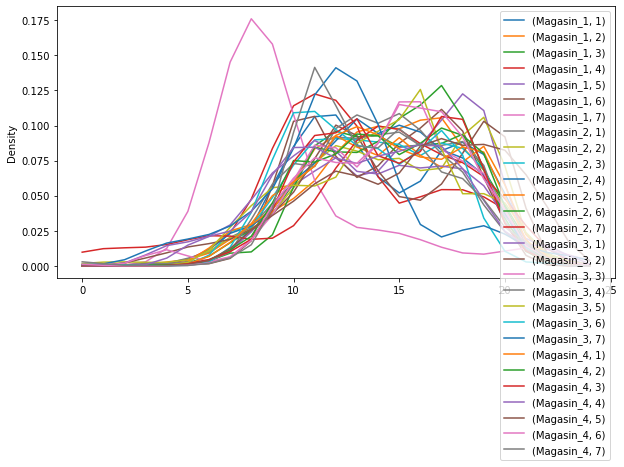

In [23]:
plt.figure(figsize=(10,5))
df.groupby(['shopping_center_id', 'day']).hour.plot.kde(ind=[j for j in range(25)]);
plt.legend()

Pour plus de **lisibilité** on va séparer ces courbes sur 4 graphes pour les 4 magasins en scindant les dataframes et en utilisant des subplots.

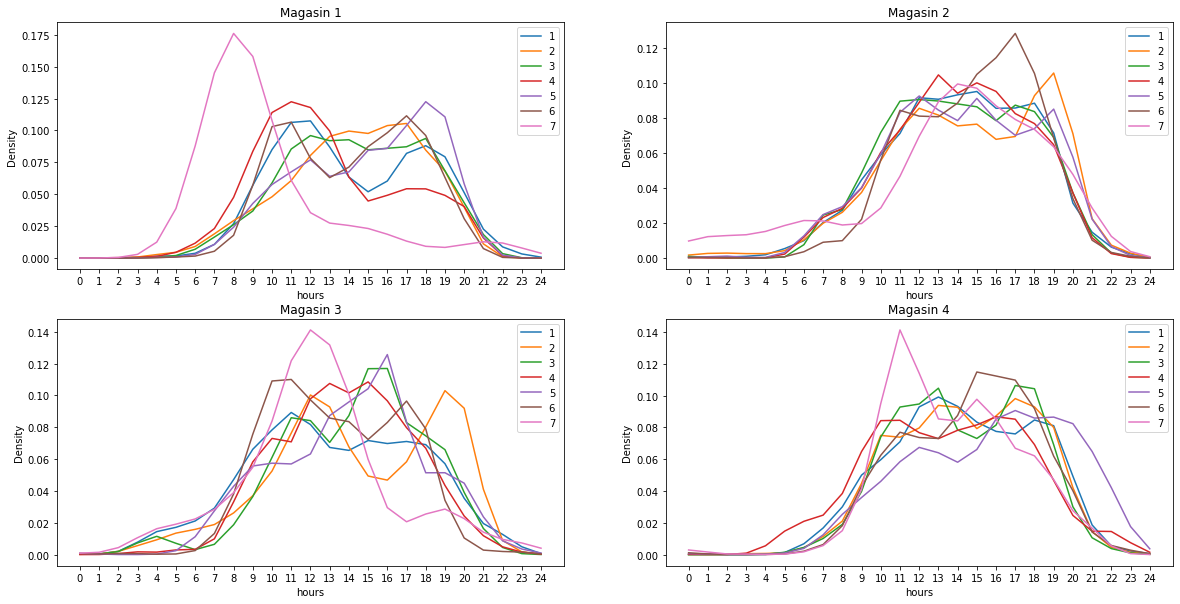

In [24]:
df_1 = df[df['shopping_center_id'] == 'Magasin_1']
df_2 = df[df['shopping_center_id'] == 'Magasin_2']
df_3 = df[df['shopping_center_id'] == 'Magasin_3']
df_4 = df[df['shopping_center_id'] == 'Magasin_4']

figure = plt.figure(figsize=(20,10))

axes = figure.add_subplot(2,2,1)
axes.set_xlabel('hours')
axes.set_ylabel('frequentation')
xticks(np.linspace(0,24,25,endpoint=True))
df_1.groupby(['day']).hour.plot.kde(ind=[j for j in range(25)])
plt.title('Magasin 1')
plt.legend()

axes = figure.add_subplot(2,2,2)
axes.set_xlabel('hours')
axes.set_ylabel('frequentation')
xticks(np.linspace(0,24,25,endpoint=True))
df_2.groupby(['day']).hour.plot.kde(ind=[j for j in range(25)])
plt.title('Magasin 2')
plt.legend()

axes = figure.add_subplot(2,2,3)
axes.set_xlabel('hours')
axes.set_ylabel('frequentation')
xticks(np.linspace(0,24,25,endpoint=True))
df_3.groupby(['day']).hour.plot.kde(ind=[j for j in range(25)])
plt.title('Magasin 3')
plt.legend()

axes = figure.add_subplot(2,2,4)
axes.set_xlabel('hours')
axes.set_ylabel('frequentation')
xticks(np.linspace(0,24,25,endpoint=True))
df_4.groupby(['day']).hour.plot.kde(ind=[j for j in range(25)])
plt.title('Magasin 4')
plt.legend()

A partir de ces courbes, on règle les paramètres des horaires d'ouverture/fermeture plus haut.

# Algorithme de prédiction - horaires fermeture - magasin 1

D'après l'arbre de décision de la librairie scikit-learn (cf .ppt), s'agissant d'un problème de régression avec m<100.000, on peut choisir comme premier modèle un **SGD-Regressor**.

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
trainset, testset = train_test_split(df_ferm, test_size=0.2, random_state=0)

In [27]:
df_ferm_1 = df_ferm[df_ferm['shopping_center_id'] == 'Magasin_1'] #horaire du fermeture du magasin 1
df_ferm_1 = df_ferm_1.drop('shopping_center_id', axis = 1) #on enlève la colonne magasin puisque c'est uniquement pour le magasin 1
print(df_ferm_1)

   day   hour
0    1  21.00
1    2  20.00
2    3  20.00
3    4  20.00
4    5  20.00
5    6  20.00
6    7  21.46


In [28]:
#def encodage(df_ferm):
   # code = {'Magasin_1':1, 'Magasin_2':2, 'Magasin_3':3, 'Magasin_4':4}
    #df_ferm['shopping_center_id']=df_ferm['shopping_center_id'].map(code)

In [29]:
def preprocessing(df_ferm):
    #df_ferm = encodage(df_ferm)
    # = df_ferm.drop('hour', axis=1)
    X = df_ferm_1.drop(columns=['hour'])
    y = df_ferm_1['hour']
    print(y.value_counts())
    return X, y

In [30]:
X_train, y_train = preprocessing(trainset)

20.00    5
21.46    1
21.00    1
Name: hour, dtype: int64


In [31]:
X_test, y_test = preprocessing(testset)

20.00    5
21.46    1
21.00    1
Name: hour, dtype: int64


Trop peu de valeurs (7) pour appliquer le SGD Regressor. A ce stade, il faudrait réaliser à nouveau l'étude **en utilisant les timeseries**.